In [1]:
import jax
import jax.numpy as jnp
from matplotlib import pyplot as plt
from tqdm import tqdm

### 0. The Geodesics of the Sphere $S^2$

The 2-sphere can be parametrised by two Euler angles $\theta, \phi$. One inherits the metric of the ambient space $\mathbb{R}^3$ and obtains a Riemannian manifold with metric:

$$
ds^2 =  d\theta^2 + \sin^2 \theta \, d\phi^2
$$

One can employ the Levi-Civita connection and calculate geodesics. We aim to do this numerically and later generalise to high-dimensional settings where only lowering indices via the metric tensor g is numerically available. Also raising indices is available, though it involves inverting the above metric or using approximate solvers for linear systems of equations. The lowering of indices is written as:

$$
w_i = g_{ij} v^j
$$

We implement it in the folowing snippet:

In [2]:
def apply_g(primals, tangent):

    theta = primals[0]
    orig_shape = tangent.shape
    tangent = tangent.reshape(-1, 2, 1)

    g = jnp.array([[1., 0],[0, jnp.sin(theta)**2]])
    res = jnp.matmul(g, tangent)
    return res.reshape(orig_shape)

In [3]:
param = jnp.array([0., 1.])
tangents = jnp.ones(shape = (20, 2))

cotangents = apply_g(param, tangents)
cotangents.shape

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


(20, 2)

Using a numerical linear eqation solver (conjugate gradient), we can also raise indices:

In [4]:
def inverse_g(primals, cotangent):
    A = lambda tangents : apply_g(primals, tangents)
    return jax.scipy.sparse.linalg.cg(A, cotangent)[0]

In [5]:
tangents = inverse_g(param, cotangents)
tangents.shape

(20, 2)

We now aim to solve the geodesic equation on this Riemannian manifold. It describes the trajectory of a curve $\gamma : \mathbb{R} \to M$, given by:

$$
\"{\gamma}^i + \Gamma^i_{jk} \dot{\gamma}^j \dot{\gamma}^k = 0
$$

This involves the Christoffel-symbols $\Gamma$ of the Levi-Civita connection, given by:
$$
\Gamma^i_{jk} = \frac{1}{2}g^{il} b_{ljk}
$$

with $b_{ljk} = \partial_j g_{lk} + \partial_k g_{lj} - \partial_l g_{jk}$. We first calculate the expression $b_{ljk}\dot{\gamma}^j\dot{\gamma}^k$ and then raise its index via the conjugate gradient method described above. The first two terms of $b_{ljk}$ give the same result when contracted with $\dot{\gamma}^j\dot{\gamma}^k$. The result of the first, we will calculate with function $a$ and the second one with function $b$.

In [7]:
def a(primals, gamma_dot):
    f = lambda primals : apply_g(primals, gamma_dot)
    res = jax.jvp(f, (primals,), (gamma_dot,))
    return res[1]

def b(primals, gamma_dot):
    f = lambda primals : jnp.sum(gamma_dot * apply_g(primals, gamma_dot))
    res = jax.vjp(f, primals)[1](jnp.array(1.))[0]
    return res

@jax.jit
def geodesic_correction(primals, gamma_dot):
    lower = a(primals, gamma_dot) - 0*b(primals, gamma_dot)
    raised = inverse_g(primals, lower)
    return 0.5*raised

The implemented geodesic correction function calculates directly all components of $\Gamma^i_{jk}\dot{\gamma}^j\dot{\gamma}^k$. We will also call the collection of these components $\Gamma(\dot{\gamma},\dot{\gamma})$.

### 1. Iterative Integration Scheme
One can discretise the second order geodesic equation. Here we employ

$$
\ddot{\gamma}(t) \approx \frac{1}{\epsilon^2}\left[\gamma(t + \epsilon) - 2 \gamma(t) + \gamma(t - \epsilon)\right]
$$

for the second derivative and
$$
\dot{\gamma}(t) \approx \frac{1}{\epsilon}\left[\gamma(t) - \gamma(t - \epsilon)\right]
$$
with $\epsilon$ being a small time step. The geodesic equation then becomes:

$$
\gamma(t + \epsilon) = 2\gamma(t) - \gamma(t - \epsilon) - \Gamma(\gamma(t)-\gamma(t-\epsilon), \gamma(t)-\gamma(t-\epsilon))
$$

In [8]:
dt = 0.05
T = 15
N_iter = int(T/dt) - 2

t = 0
gamma = jnp.array([jnp.pi/2+1., 0])
gamma_dot = jnp.array([0.,1.])


ts = [t, t + dt]
gammas = [gamma - dt * gamma_dot, gamma]
for i in tqdm(range(2, N_iter)):

    delta_gam = gammas[i - 1] - gammas[i - 2]
    cor = geodesic_correction(gammas[i - 1], delta_gam)
    gamma = 2*gammas[i-1] - gammas[i - 2] - cor
    t = ts[i - 1] + dt

    ts.append(t)
    gammas.append(gamma)

gammas = jnp.array(gammas)
ts = jnp.array(ts)

100%|██████████| 296/296 [00:00<00:00, 1782.88it/s]


Text(0.5, 1.0, 'Geodesics of the sphere')

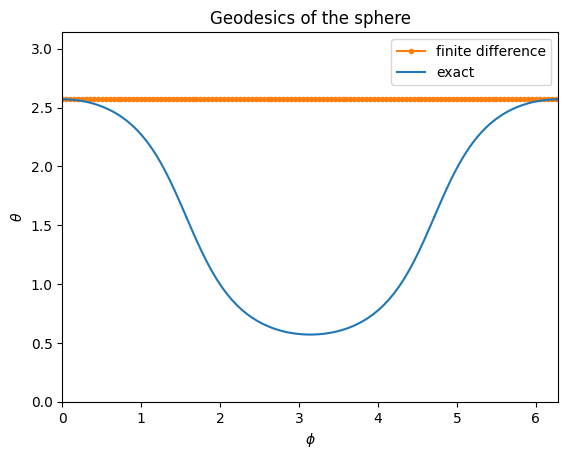

In [9]:
phis = jnp.linspace(jnp.pi/2, jnp.pi*3/2-1e-3)
phis2 = jnp.linspace(0, jnp.pi/2-1e-3)
phis3 = jnp.linspace(jnp.pi*3/2, jnp.pi*2)
coef = 1 / jnp.tan(gammas[0][0])

plt.plot(gammas[:,1], gammas[:, 0], color = "C1", marker = ".", label = "finite difference")
plt.plot(phis, jnp.arctan(1/coef/jnp.cos(phis)), color = "C0")
plt.plot(phis2, jnp.arctan(1/coef/jnp.cos(phis2))+jnp.pi, color = "C0")
plt.plot(phis3, jnp.arctan(1/coef/jnp.cos(phis3))+jnp.pi, color = "C0", label = "exact")
plt.xlim(0, jnp.pi*2)
plt.ylim(0, jnp.pi)
plt.ylabel("$\\theta$")
plt.xlabel("$\\phi$")
plt.legend()
plt.title("Geodesics of the sphere")